# Calculating Lagrangian trajectories for coupled simulation

## Loading modules

In [1]:
%matplotlib inline
from parcels import (FieldSet, ParticleSet,
                     JITParticle, ScipyParticle,
                     AdvectionRK4)
from glob import glob
import xarray as xr
import numpy as np
from datetime import timedelta, datetime

## Custom settings
### need to be checked/adjusted before every execution

In [2]:
# DEFINE INPUT DATA

############################

# set key to 'uncoupled', 'coupled_nosd', or 'coupled_sd'
key_input = 'uncoupled'

############################

datapath = '/Users/siren/Data/IMMERSE/'

gridpath = (datapath + 'domain/fgrid.nc')

if key_input == 'uncoupled':
    filepaths_u = sorted(glob(datapath + 'surface_TKE_v42RC/MED24_OBC_1d*_grid_U.nc'))
    filepaths_v = sorted(glob(datapath + 'surface_TKE_v42RC/MED24_OBC_1d*_grid_V.nc'))
    key_stokes = False
elif key_input == 'coupled_nosd':
    filepaths_u = sorted(glob(datapath + 'surface_TKE_CO_FORCE_MIX_LC015/MED24_OBC_1d*_grid_U.nc'))
    filepaths_v = sorted(glob(datapath + 'surface_TKE_CO_FORCE_MIX_LC015/MED24_OBC_1d*_grid_V.nc'))
    key_stokes = False
elif key_input == 'coupled_sd':
    filepaths_u = sorted(glob(datapath + 'surface_TKE_CO_FORCE_MIX_LC015/MED24_OBC_1d*_grid_U.nc'))
    filepaths_v = sorted(glob(datapath + 'surface_TKE_CO_FORCE_MIX_LC015/MED24_OBC_1d*_grid_V.nc'))
    key_stokes = True 
else:
    print('no (valid) key_input defined')

In [3]:
# DEFINE PARTICLE RELEASE GRID

############################

release_name = 'GulfOfLion'
lonmin = 3.5
lonmax = 4.5
latmin = 42
latmax = 43
step = 1/6

tstart_release = 0 
deltat_release = 73 # days # release from the same set of locations every 5 days
tend_release = 365 #days

############################

lons, lats = np.meshgrid(np.arange(lonmin, lonmax+step, step),
                         np.arange(latmin, latmax+step, step))
n_releasepos = lons.shape[0]*lons.shape[1]
n_releasepos
n_particles = n_releasepos * ((tend_release-tstart_release)/deltat_release)
n_particles

280.0

In [4]:
# DEFINE TRAJECTORY INTEGRATION PARAMETERS

############################

tint = 30 # days
deltat = 6 # hours

############################

In [5]:
# DEFINE LAGRANGIAN OUTPUT

############################

outdt = 1 #days

############################

procpath = '/Users/siren/IMMERSE_waves/develop-mac/data/'

if key_input == 'uncoupled':
    outpath = (procpath + 'Parcels_CalcTraj-uncoupled_Release-' + release_name)
elif key_input == 'coupled_nosd':
    outpath = (procpath + 'Parcels_CalcTraj-coupled-nosd_Release-' + release_name)
elif key_input == 'coupled_sd':
    outpath = (procpath + 'Parcels_CalcTraj-coupled-sd_Release-' + release_name)

## Create fieldset

In [6]:
filenames = {'U': {'lon': gridpath, 'lat': gridpath, 'data': filepaths_u},
             'V': {'lon': gridpath, 'lat': gridpath, 'data': filepaths_v}}
variables = {'U': 'vozocrtx',
             'V': 'vomecrty'}
if key_stokes==True:
    variables_sd = {'U': 'usd',
                    'V': 'vsd'}
dimensions = {'U': {'lon': 'glamf', 'lat': 'gphif', 'time': 'time_counter'},
              'V': {'lon': 'glamf', 'lat': 'gphif', 'time': 'time_counter'}}

In [7]:
fieldset = FieldSet.from_nemo(filenames, variables, dimensions,
                              allow_time_extrapolation=False,
                              time_periodic=False,
                              mesh='spherical')
if key_stokes==True:
    fieldset_sd = FieldSet.from_nemo(filenames, variables_sd, dimensions,
                                     allow_time_extrapolation=False,
                                     time_periodic=False,
                                     mesh='spherical')
    fieldset_sum = FieldSet(U=fieldset.U+fieldset_sd.U,
                            V=fieldset.V+fieldset_sd.V)

if key_stokes==True:
    fieldset_use = fieldset_sum
else:
    fieldset_use = fieldset

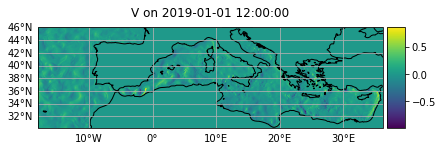

In [8]:
fieldset.V.show()

In [9]:
if key_stokes==True:
    fieldset_sd.V.show()

## Build and execute particle set using (summed) velocities

In [11]:
for times in range(tstart_release, tend_release, deltat_release):
    
    pset = ParticleSet(fieldset=fieldset_use,
                       pclass=ScipyParticle,
                       lon=lons, lat=lats, time=times)
    pset.populate_indices()
    
    pset.set_variable_write_status('depth', False)
    outpath_final = (outpath + '-d' + str(times) + '_Int-d' + str(tint) + '.nc' )
    outfile = pset.ParticleFile(outpath_final, 
                                outputdt=timedelta(days=outdt))
    kernels = pset.Kernel(AdvectionRK4)
    pset.execute(kernels,
                 runtime=timedelta(days=tint),
                 dt=timedelta(hours=deltat),
                 output_file=outfile)
    outfile.export()
    outfile.close()

INFO: Temporary output files are stored in /Users/siren/IMMERSE_waves/develop-mac/data/out-MCYRGQJZ.
INFO: You can use "parcels_convert_npydir_to_netcdf /Users/siren/IMMERSE_waves/develop-mac/data/out-MCYRGQJZ" to convert these to a NetCDF file during the run.
100% (2592000.0 of 2592000.0) |##########| Elapsed Time: 0:00:01 Time:  0:00:01
INFO: Temporary output files are stored in /Users/siren/IMMERSE_waves/develop-mac/data/out-HFGHQPNE.
INFO: You can use "parcels_convert_npydir_to_netcdf /Users/siren/IMMERSE_waves/develop-mac/data/out-HFGHQPNE" to convert these to a NetCDF file during the run.
100% (2592000.0 of 2592000.0) |##########| Elapsed Time: 0:00:04 Time:  0:00:04
INFO: Temporary output files are stored in /Users/siren/IMMERSE_waves/develop-mac/data/out-PIHRQZPK.
INFO: You can use "parcels_convert_npydir_to_netcdf /Users/siren/IMMERSE_waves/develop-mac/data/out-PIHRQZPK" to convert these to a NetCDF file during the run.
100% (2592000.0 of 2592000.0) |##########| Elapsed Time: 